<a href="https://colab.research.google.com/github/oconcito8/deeplearningextraordinaria/blob/main/Practica3DL(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Práctica LAB3 IA Generativa - Imágenes**

GRUPO: A08

CARLOS OCON GARAY.

PEDRO GARCIA SILGO

Ejercicio 1: Entrenar un Variational Autoencoder con la base de dados keras.datasets.fashion_mnist (con las imágenes de Zalando). Una vez que entrenado el modelo, usar la red decoder para convertir vectores espaciales latentes arbitrarios en imágenes. (Mostrar un ejemplo del espacio latente)


# Librerías necesarias para la ejecución de la práctica.


In [75]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, Model, metrics, losses
import os
from glob import glob
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, LeakyReLU, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Carga y Preparación del Conjunto de Datos Fashion MNIST


In [59]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

# Normalizar los datos y agregar un canal adicional
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Dimensiones de entrada
input_shape = x_train.shape[1:]


# Visualización de Imágenes del Conjunto de Datos

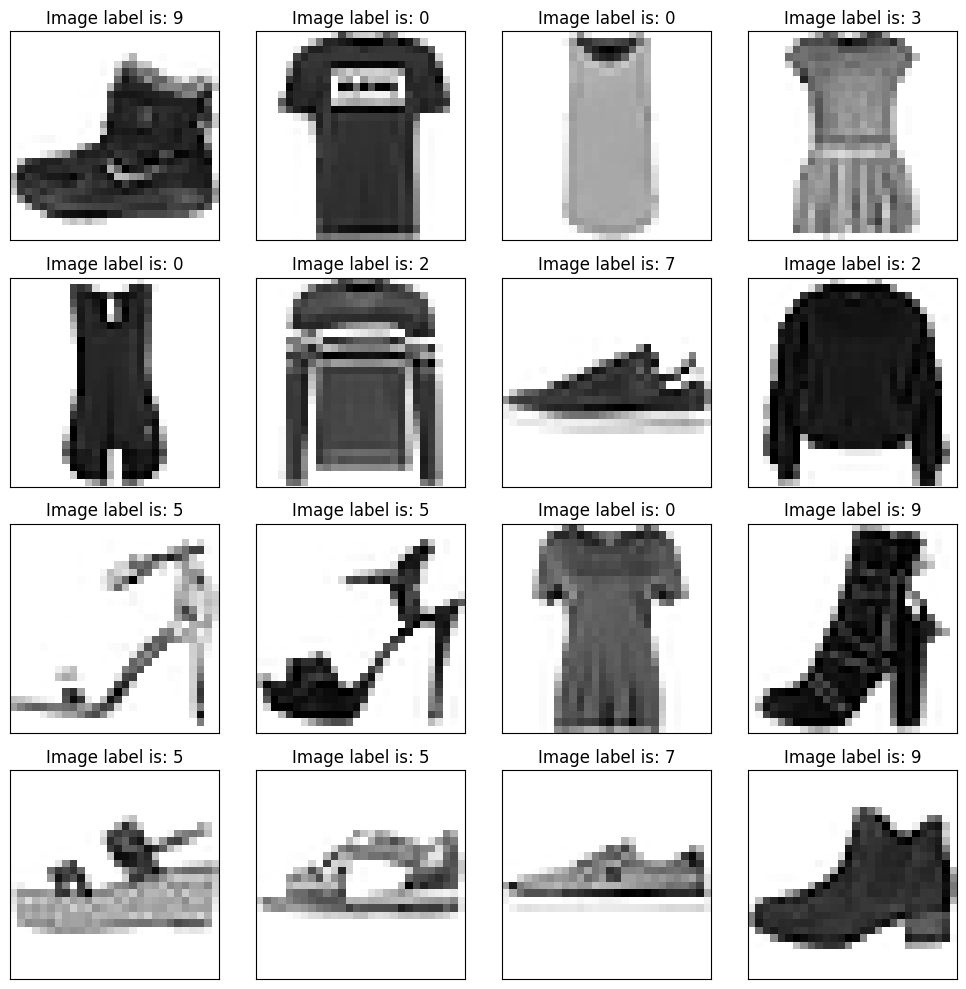

In [51]:
def plot_images(images, labels, num_rows=4, num_cols=4, cmap='binary'):
    """Plot a grid of images with their labels."""
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        if i < len(images):
            ax.imshow(images[i], cmap=cmap)
            ax.set_title(f"Image label is: {labels[i]}")


        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(False)

    plt.tight_layout()
    plt.show()


plot_images(train_images, train_labels)

MODELO

# Construcción del Codificador de un Autoencoder Variacional

se construye la parte del codificador de un Autoencoder Variacional (VAE). El codificador toma imágenes de entrada y las pasa a través de varias capas convolucionales para extraer características importantes. Después de aplanar estas características, se utilizan dos capas densas para calcular los parámetros de la distribución latente: la media (z_mean) y la varianza logarítmica (z_log_var). Una función de muestreo (sampling) utiliza estos parámetros para generar puntos en el espacio latente aplicando una reparametrización, que permite la backpropagation durante el entrenamiento. El modelo resultante, llamado encoder, incluye todas estas operaciones y se resume al final de la sección.

In [60]:
latent_dim = 2  # Dimensión del espacio latente

# Encoder
inputs = Input(shape=input_shape)
x = Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = Conv2D(64, 3, activation='relu', padding='same', strides=(2, 2))(x)
x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = Conv2D(64, 3, activation='relu', padding='same')(x)
shape_before_flattening = K.int_shape(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)

z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.0)
    return z_mean + K.exp(z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_18 (InputLayer)       [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_26 (Conv2D)          (None, 28, 28, 32)           320       ['input_18[0][0]']            
                                                                                                  
 conv2d_27 (Conv2D)          (None, 14, 14, 64)           18496     ['conv2d_26[0][0]']           
                                                                                                  
 conv2d_28 (Conv2D)          (None, 14, 14, 64)           36928     ['conv2d_27[0][0]']           
                                                                                            

El modelo del codificador (encoder) del Autoencoder Variacional (VAE) se ha construido con varias capas convolucionales y densas, culminando en una representación latente de baja dimensionalidad.

InputLayer: Recibe imágenes de 28x28 píxeles en escala de grises.

Capas Convolucionales:Cuatro capas convolucionales con activación ReLU.
La primera capa mantiene la resolución, mientras que la segunda la reduce a la mitad.
Las capas convolucionales extraen características importantes de las imágenes.

Flatten:Convierte las características en un vector 1D para su procesamiento posterior.

Capas Densas:Una capa densa reduce la dimensionalidad a 32 unidades.
Dos capas densas adicionales generan la media (z_mean) y la varianza logarítmica (z_log_var) del espacio latente.
Lambda: Una capa Lambda realiza el muestreo del espacio latente utilizando la reparametrización.

El codificador reduce las imágenes de entrada a una representación latente de 2 dimensiones, esencial para el funcionamiento del VAE, permitiendo generar nuevas imágenes a partir de esta representación compacta. Es una parte crucial del VAE, proporcionando una manera eficiente de codificar las imágenes en un espacio latente de baja dimensionalidad que puede ser utilizado para la generación de nuevas imágenes.

# Decodificador del Autoencoder Variacional (VAE)

In [61]:
latent_inputs = Input(shape=(latent_dim,))

# Producimos la misma cantidad de coeficientes que teníamos al nivel de la capa Flatten en el codificador.
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
# Revertimos la capa Flatten del codificador.
x = layers.Reshape((7, 7, 64))(x)
# Revertimos las capas Conv2D del codificador.
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
# La salida termina con la forma (28, 28, 1)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")

decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_26 (Dense)            (None, 3136)              9408      
                                                                 
 reshape_9 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_33 (Conv2  (None, 14, 14, 64)        36928     
 DTranspose)                                                     
                                                                 
 conv2d_transpose_34 (Conv2  (None, 28, 28, 32)        18464     
 DTranspose)                                                     
                                                                 
 conv2d_30 (Conv2D)          (None, 28, 28, 1)         289 

El decodificador se encarga de revertir el proceso del codificador, transformando la representación latente de baja dimensionalidad de vuelta a imágenes de 28x28 píxeles. Este proceso incluye la expansión inicial de la representación latente, seguida de una serie de operaciones de convolución transpuesta que restauran la resolución y estructura de la imagen original.


# Conexión del Encoder y el Decoder del Autoencoder Variacional (VAE)


In [62]:
# Conectar el encoder y el decoder
z_mean, z_log_var, z = encoder(inputs)
outputs = decoder(z)
vae = Model(inputs, outputs, name='vae')

# Definir la pérdida VAE
reconstruction_loss = binary_crossentropy(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= np.prod(input_shape)
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()


Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_18 (InputLayer)       [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 encoder (Functional)        [(None, 2),                  494244    ['input_18[0][0]']            
                              (None, 2),                                                          
                              (None, 2)]                                                          
                                                                                                  
 decoder (Functional)        (None, 28, 28, 1)            65089     ['encoder[0][2]']             
                                                                                                

En esta sección del código, se conectan el encoder y el decoder para formar el modelo completo del VAE. Además, se define la función de pérdida del VAE, que combina la pérdida de reconstrucción y la pérdida KL divergente, y se compila el modelo. El encoder toma las imágenes de entrada y produce una representación latente que es alimentada al decoder para generar las imágenes reconstruida

# Entrenamiento del Autoencoder Variacional (VAE)
 Se entrena el modelo VAE utilizando los datos de entrenamiento de Fashion MNIST. El entrenamiento se realiza durante 5 épocas con un tamaño de lote de 128 y se evalúa el rendimiento en el conjunto de datos de prueba.

In [63]:
vae.fit(x_train, epochs=5, batch_size=128, validation_data=(x_test, None))


Epoch 1/5
469/469 [==============================] - 285s 603ms/step - loss: 369.3043 - val_loss: 347.3480
Epoch 2/5
469/469 [==============================] - 291s 621ms/step - loss: 345.1725 - val_loss: 347.2956
Epoch 3/5
469/469 [==============================] - 282s 602ms/step - loss: 342.6284 - val_loss: 341.8918
Epoch 4/5
469/469 [==============================] - 273s 581ms/step - loss: 340.4051 - val_loss: 339.7801
Epoch 5/5
469/469 [==============================] - 271s 578ms/step - loss: 337.8894 - val_loss: 337.3697


# Visualización de Imágenes Originales y Reconstruidas con el Autoencoder Variacional (VAE)

Ingrese el índice de la imagen a mostrar: 2
1/1 [==============================] - 0s 33ms/step


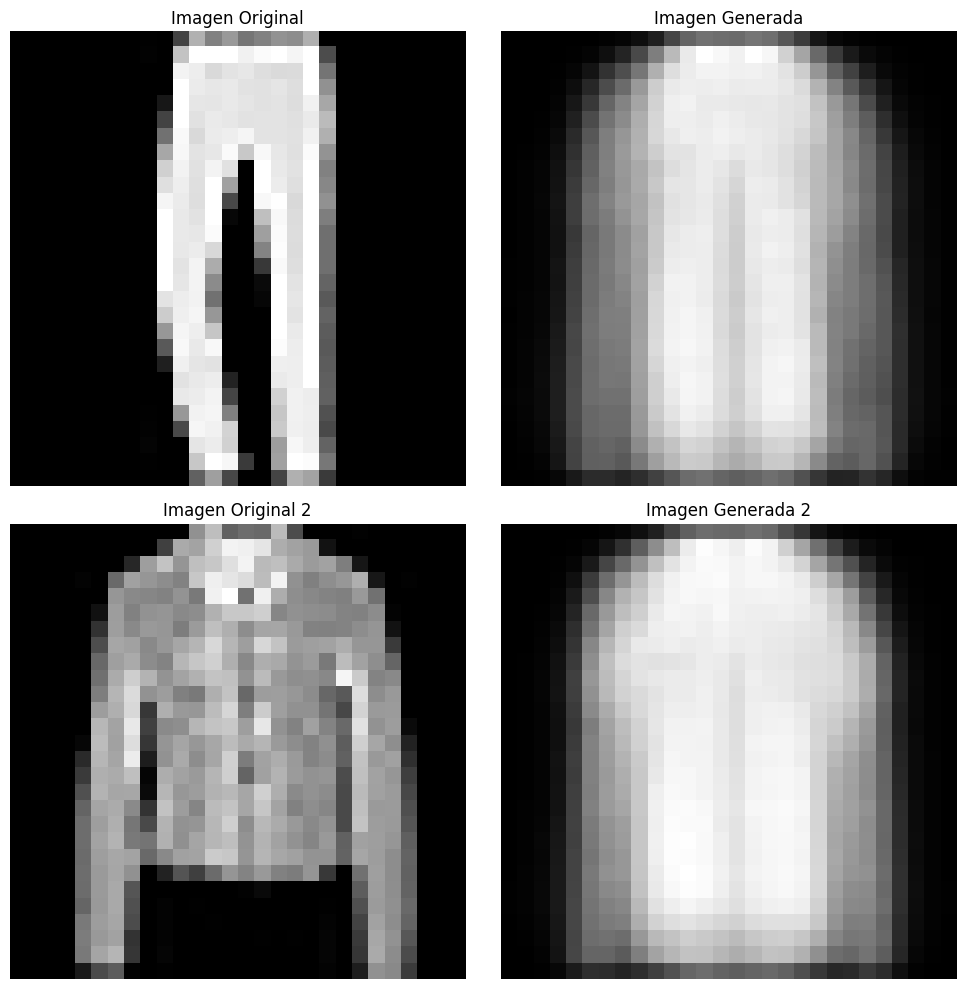

In [68]:
import matplotlib.pyplot as plt

# Función para mostrar imágenes originales y generadas
def show_images_and_reconstructions(index, images, encoder, decoder):
    # Obtener la imagen original
    img = images[index]
    img_expanded = np.expand_dims(img, axis=0)

    # Obtener la representación latente y reconstruir la imagen
    z_mean, z_log_var, z = encoder.predict(img_expanded)
    reconstructed_img = decoder.predict(z)

    # Obtener otra imagen original y su reconstrucción
    img2 = images[index * 5]
    img2_expanded = np.expand_dims(img2, axis=0)
    z_mean2, z_log_var2, z2 = encoder.predict(img2_expanded)
    reconstructed_img2 = decoder.predict(z2)

    # Mostrar las imágenes originales y reconstruidas
    plt.figure(figsize=(10, 10))

    plt.subplot(221)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title("Imagen Original")
    plt.axis('off')

    plt.subplot(222)
    plt.imshow(reconstructed_img.squeeze(), cmap='gray')
    plt.title("Imagen Generada")
    plt.axis('off')

    plt.subplot(223)
    plt.imshow(img2.squeeze(), cmap='gray')
    plt.title("Imagen Original 2")
    plt.axis('off')

    plt.subplot(224)
    plt.imshow(reconstructed_img2.squeeze(), cmap='gray')
    plt.title("Imagen Generada 2")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Solicitar el índice de la imagen a mostrar
index = int(input("Ingrese el índice de la imagen a mostrar: "))

# Mostrar las imágenes y sus reconstrucciones
show_images_and_reconstructions(index, x_test, encoder, decoder)


1/1 [==============================] - 0s 22ms/step


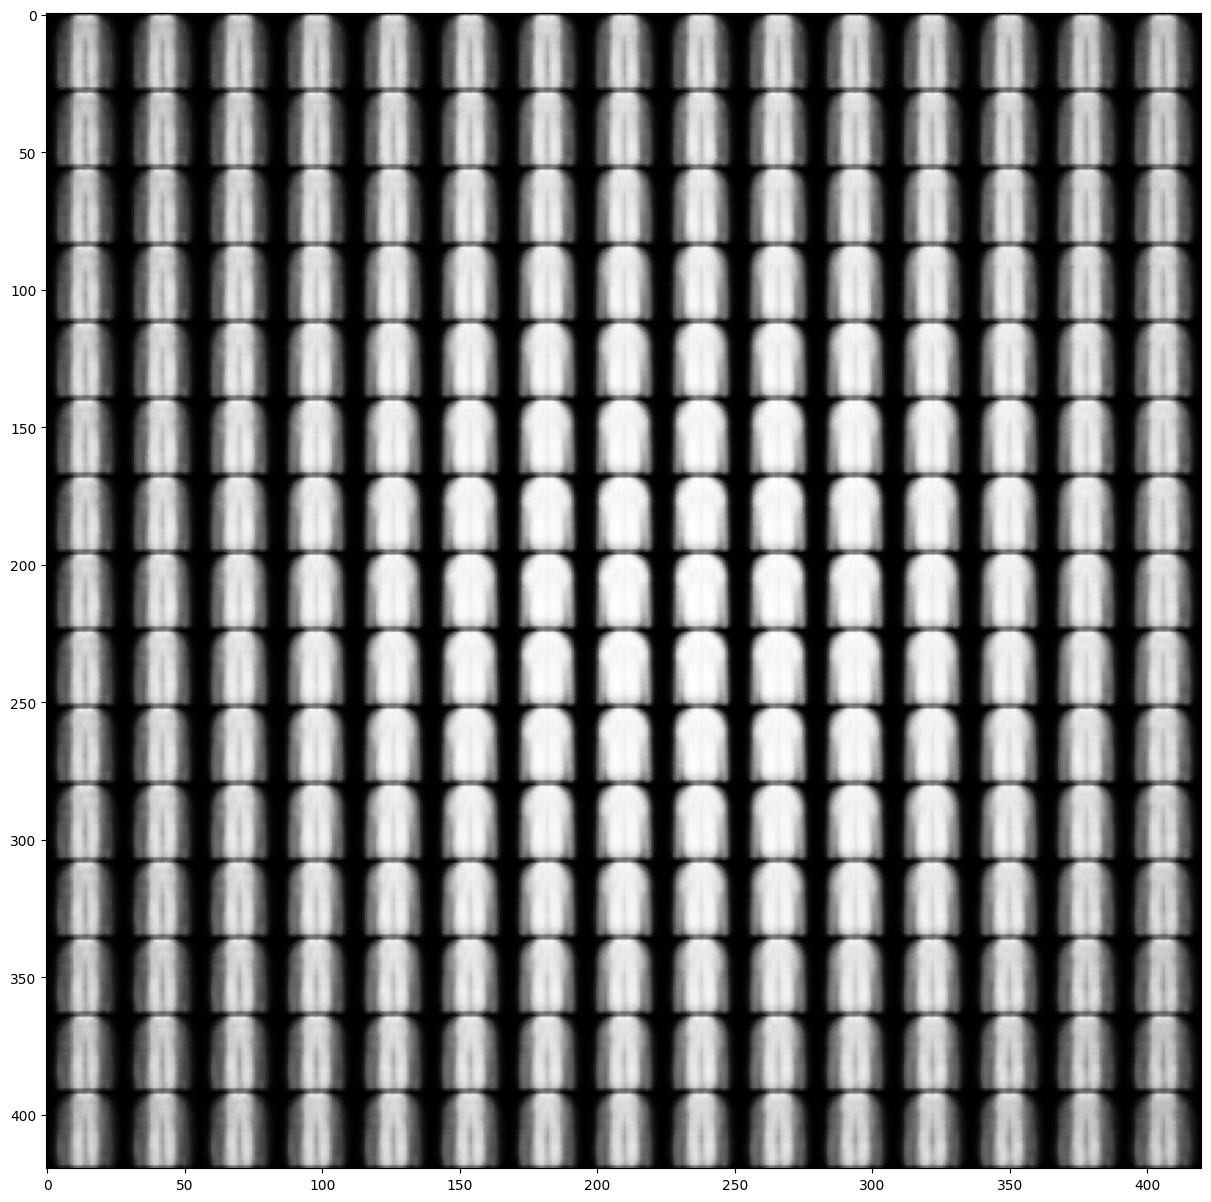

In [64]:
def plot_latent_space(decoder, n=15, figsize=15):
    # Display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

# Graficar el espacio latente
plot_latent_space(decoder)


### Conclusión

El Autoencoder Variacional (VAE) proporciona una poderosa herramienta para aprender representaciones latentes compactas de datos complejos, como imágenes. La visualización de las imágenes originales y sus reconstrucciones generadas por el VAE nos permite evaluar la capacidad del modelo para capturar las características esenciales de las imágenes y reproducirlas fielmente.

En esta implementación, se observa que las imágenes reconstruidas se asemejan a las originales, aunque no de manera perfecta, debido al número limitado de épocas con las que se entrenó el modelo. Esto sugiere que el VAE ha aprendido una representación básica en el espacio latente, aunque no de manera óptima. Sin embargo, a simple vista, las imágenes generadas parecen haber capturado algunas de las características principales de las originales, lo cual es un buen indicio del potencial del modelo.

La representación latente de baja dimensionalidad permite no solo la reconstrucción de las imágenes originales, sino también la generación de nuevas imágenes interpolando en este espacio latente. Esta capacidad es visualizada a través de un mapeo del espacio latente, donde se pueden generar nuevas imágenes al muestrear diferentes puntos dentro de este espacio.

El mapeo del espacio latente muestra una transición suave entre diferentes tipos de imágenes, lo que evidencia la continuidad y estructura del espacio latente aprendido por el VAE. Esta característica es crucial para aplicaciones en las que se requiere generar nuevas muestras realistas, como en la generación de datos sintéticos, la creación de arte y en muchas otras aplicaciones creativas e industriales.

En resumen, aunque el VAE en esta implementación inicial no ha alcanzado su máximo potencial debido al entrenamiento limitado, su capacidad para aprender representaciones latentes y generar imágenes que capturan las características principales de las originales subraya su utilidad y potencia en el campo del aprendizaje profundo y la generación de datos. Con más entrenamiento, es probable que el modelo mejore significativamente en la calidad de las imágenes reconstruidas.